# Urban Efficiency 2025 — Analysis

### Introduction

Is there a proportional relationship between income levels and purchasing power?  
And does a higher purchasing power necessarily translate into a higher living efficiency?

This analysis explores the relationship between income, purchasing power, and living costs across selected cities, aiming to assess whether stronger purchasing power truly reflects a more efficient standard of living once cost factors are taken into account.


**Setup:** Run the next cell if you need to install the Python dependencies used in this notebook. If your environment already has these packages, you can skip it.

In [ ]:
# Install required packages (run only if missing)
%pip install mysql-connector-python matplotlib seaborn openpyxl pandas squarify

## Imports
Import commonly-used libraries and visualization tools.

In [2]:
# Import libraries used in analysis
import pandas as pd  # data frames and I/O
import numpy as np  # numeric utilities
import matplotlib.pyplot as plt  # plotting backend
import seaborn as sns  # statistical visualizations
import mysql.connector  # database connection
import squarify  # treemap plotting (optional)
import os # operating system utilities


## Database connection
Provide credentials to connect to the MySQL database.

### Security Note
Database credentials are not hard-coded in this notebook.  
Sensitive information such as passwords is handled using environment variables to follow basic security best practices and ensure the notebook can be safely shared or published.


In [3]:
# Establish a connection to the MySQL database
DB_PASSWORD = os.getenv("DB_PASSWORD")

if DB_PASSWORD is None:
    raise ValueError("Database password not found in environment variables")
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=DB_PASSWORD,
    database="urban_efficiency_2025"
)
cursor = conn.cursor()

## Inspect table columns
List columns of the `cost_of_living_indices` table to confirm the schema before querying.

In [ ]:
# Query INFORMATION_SCHEMA to list column names for the target table
query = """
    SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS \
WHERE TABLE_NAME = 'cost_of_living_indices' \
  AND TABLE_SCHEMA = 'urban_efficiency_2025';
  """
cursor.execute(query)
for row in cursor.fetchall():
    print(f"  - {row[0]}")

## Helper: Run a SQL query and return a DataFrame
A small utility to execute SQL and convert results to a `pandas.DataFrame`.

In [5]:
def q(sql: str) -> pd.DataFrame:
    """Execute SQL and return a pandas DataFrame.
    Keeps code concise when running multiple queries.
    """
    cursor.execute(sql)
    rows = cursor.fetchall()
    cols = [d[0] for d in cursor.description]
    return pd.DataFrame(rows, columns=cols)

## Compute `efficiency_score` and Rankings

### Efficiency Score Definition

The efficiency score is designed to measure how favorable a city is in terms of purchasing power relative to living expenses.

The metric is defined as:

Efficiency Score = Purchasing Power Index / (Cost of Living Index + Rent Index)

This formulation reflects the idea that higher purchasing power improves efficiency, while higher living and housing costs reduce it. Combining cost of living and rent in the denominator provides a more realistic representation of total financial pressure on individuals.


### Handling Edge Cases and Outliers
To avoid distorted efficiency values, cases where the denominator (Cost of Living Index + Rent Index) is zero or unrealistically low are excluded from the analysis.

In practice, rows with `col_plus_rent_index <= 10` are treated as invalid for this metric and their `efficiency_score` is set to `NULL`.

This ensures numerical stability and prevents artificially inflated efficiency scores.



### Ranking Interpretation

Cities are ranked based on their efficiency score in descending order.

A higher efficiency score indicates a more favorable balance between purchasing power and living costs. Therefore, cities appearing at the top of the ranking are considered relatively more efficient from a cost-adjusted income perspective.


In [10]:
# Build rankings DataFrame from database
df_rank = q("""
SELECT
  city, country, year, col_index, rent_index, col_plus_rent_index, purchasing_power_index,
  CASE
  WHEN col_plus_rent_index <= 10 THEN NULL
  ELSE ROUND(purchasing_power_index / col_plus_rent_index, 3)
END AS efficiency_score

FROM cost_of_living_indices
ORDER BY efficiency_score DESC;
""")
# Show top rows to verify results
df_rank.head()

,city,country,year,col_index,rent_index,col_plus_rent_index,purchasing_power_index,efficiency_score
0,Jeddah,SA,2025,41.9,11.8,28.6,151.2,5.287
1,Muscat,OM,2025,40.4,14.2,28.8,112.7,3.913
2,Kuwait City,KW,2025,42.0,22.1,33.2,128.5,3.870
3,Riyadh,SA,2025,47.3,25.4,37.6,134.2,3.569
4,Abu Dhabi,AE,2025,52.6,36.1,45.3,158.8,3.506


### City Selection Rationale

The selected cities represent a mix of major economic centers, high-cost metropolitan areas, and cities commonly considered for work or migration.

This selection allows for meaningful comparison across different cost structures and income environments rather than focusing on a single geographic category.


In [9]:
# Query a pair of cities for comparison
df_pair = q("""
SELECT
  city, country, col_index, rent_index, col_plus_rent_index, purchasing_power_index,
  CASE
  WHEN col_plus_rent_index <= 10 THEN NULL
  ELSE ROUND(purchasing_power_index / col_plus_rent_index, 3)
END AS efficiency_score
FROM cost_of_living_indices
WHERE city IN ('Riyadh', 'Istanbul')
ORDER BY city;
""")
df_pair

,city,country,col_index,rent_index,col_plus_rent_index,purchasing_power_index,efficiency_score
0,Istanbul,TR,39.8,20.1,31.1,52.6,1.691
1,Riyadh,SA,47.3,25.4,37.6,134.2,3.569


## Correlation matrix
Visualize correlations between the cost/rent indices, purchasing power, and the computed efficiency score.

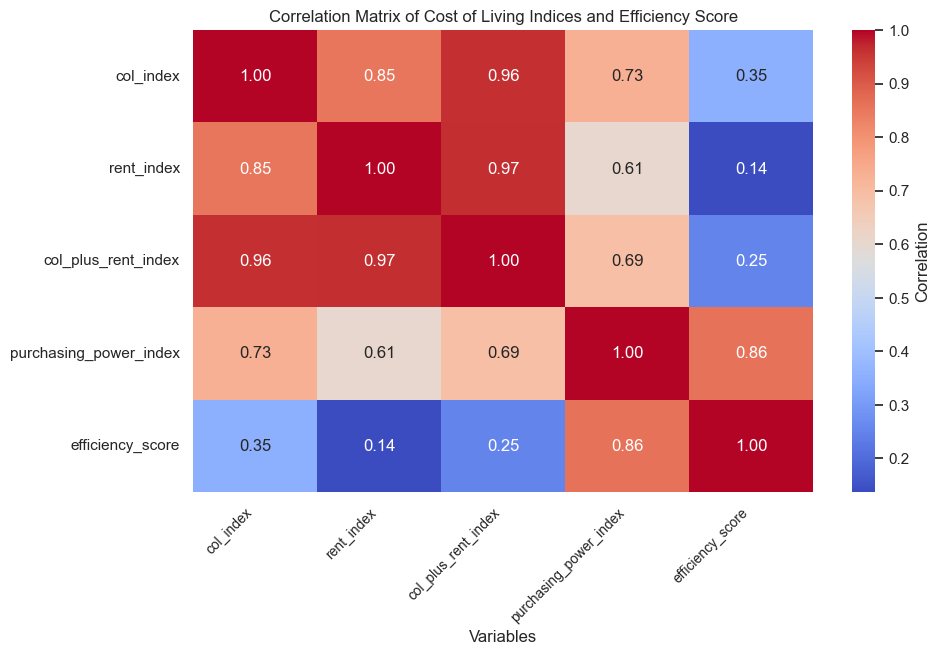

In [13]:
# Compute correlation matrix for selected numeric columns
corr_matrix = df_rank[['col_index', 'rent_index', 'col_plus_rent_index', 'purchasing_power_index', 'efficiency_score']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation'}, annot_kws={'fontsize':12})
plt.xlabel('Variables', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Correlation Matrix of Cost of Living Indices and Efficiency Score')
plt.show()

## Closing Notes

This notebook focuses on data preparation, metric definition, and preliminary analysis.

The resulting dataset is intended to be used in Power BI for interactive visualization and further exploratory analysis. Any design-related decisions and comparative insights will be handled at the dashboard level.


## Export results and close connection
Save the derived CSVs and then close the database cursor and connection.

In [ ]:
# Export results to CSV files for downstream use
df_rank.to_csv('urban_efficiency_rankings.csv', index=False)
df_pair.to_csv('urban_efficiency_riyadh_istanbul.csv', index=False)
# Close database connection (important!)
cursor.close()
conn.close()